In [20]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

import pickle
import math
#import app
import tqdm
from tqdm import trange

import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [3]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
#device='cpu'

device(type='cuda', index=0)

# load data

In [4]:
with open('../data_pickle/resized64_train_data256.pickle', 'rb') as f :
    train = pickle.load(f)
with open('../data_pickle/resized64_valid_data256.pickle', 'rb') as f :
    valid = pickle.load(f)
with open('../data_pickle/resized64_test_data256.pickle', 'rb') as f :
    test = pickle.load(f)

In [5]:
X_train = np.array(train['train_data'])
Y_train = np.array(train['train_label'])
X_val = np.array(valid['valid_data'])
Y_val = np.array(valid['valid_label'])
X_test = np.array(test['test_data'])
Y_test = np.array(test['test_label'])

In [6]:
X_train.shape

(63325, 64, 64, 3)

# plot image

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:>]


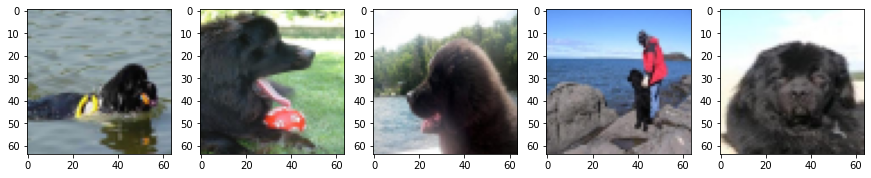

In [7]:
#圖片展示
#opencv读取到的图片是BGR格式的，Matplotlib按照RGB格式解析的
import cv2
fig,ax = plt.subplots(1,5,figsize = (15,3))
print(ax)
for idx, vactor in enumerate(X_train[:5]):
    ax[idx].imshow(cv2.cvtColor(vactor, cv2.COLOR_BGR2RGB))

# define FC

In [8]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*13*13, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 50)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16*13*13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def accuracy(self, x, t, k ):
        y = self.forward(x)
        y_hat_k = y.argsort(axis=1)[:,-k:]
        lst = []
        for i in range(len(t)):
            lst.append(t[i] in y_hat_k[i,:])
        accuracy = np.mean(lst)
        return accuracy


In [9]:
#標準化
def custom_normalization(data, std, mean):
    return (data - mean) / std

# mean, std = X_train.mean(), X_train.std()
# X_train = custom_normalization(X_train, mean, std)
# mean, std = X_val.mean(), X_val.std()
# X_val = custom_normalization(X_val, mean, std)
# mean, std = X_test.mean(), X_test.std()
# X_test = custom_normalization(X_test, mean, std)

In [10]:
X_train = np.transpose(X_train,(0,3,1,2))
X_val = np.transpose(X_val,(0,3,1,2))
X_test = np.transpose(X_test,(0,3,1,2))

In [28]:
#使用pytorch封装的dataloader进行训练和预测

#use_gpu = torch.cuda.is_available()
batch_size = 16
#kwargs = {'num_workers': 2, 'pin_memory': True} if use_gpu else {}

train_x, train_y = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train.astype(int))
val_x, val_y = torch.from_numpy(X_val).float(),torch.from_numpy(Y_val.astype(int))
test_x, test_y = torch.from_numpy(X_test).float(),torch.from_numpy(Y_test.astype(int))

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=450)


In [12]:
# Hyper parameters

num_epochs = 10
num_classes = 50
learning_rate = 0.001

In [16]:
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [17]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
train_acc_list = []
valid_acc_list = []
test_acc_list = []
train_acc_5_list = []
valid_acc_5_list = []
test_acc_5_list = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0

    # training-the-model
    model.train()
    for X_train_batch, Y_train_batch in train_loader:
        # move-tensors-to-GPU if you have.
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        
        mean, std = X_train_batch.mean(), X_train_batch.std()
        X_train_batch = custom_normalization(X_train_batch, mean, std)
        
        optimizer.zero_grad()
        output = model(X_train_batch)
        loss = criterion(output, Y_train_batch.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_train_batch.size(0)
        
    # validate-the-model
    model.eval()
    for X_val_batch, Y_val_batch in valid_loader:

        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        
        mean, std = X_val_batch.mean(), X_val_batch.std()
        X_val_batch = custom_normalization(X_val_batch, mean, std)
        
        output = model(X_val_batch)
        
        loss = criterion(output, Y_val_batch.long())
        
        # update-average-validation-loss 
        valid_loss += loss.item() * X_val_batch.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    #if epoch % 10 == 0:
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    if epoch % 1 == 0:
        train_acc = model.accuracy(X_train_batch, Y_train_batch, k= 1) 
        valid_acc = model.accuracy(X_val_batch, Y_val_batch, k= 1)  
        #test_acc = model.accuracy(X_test, Y_test, k= 1)
        
        train_acc_5 = model.accuracy(X_train_batch, Y_train_batch, k= 5) 
        valid_acc_5 = model.accuracy(X_val_batch, Y_val_batch, k= 5)  
        #test_acc_5 = model.accuracy(X_test, Y_test, k= 5)
        
        train_acc_list.append(train_acc) 
        valid_acc_list.append(valid_acc)
        #test_acc_list.append(test_acc)     
        
        train_acc_5_list.append(train_acc_5) 
        valid_acc_5_list.append(valid_acc_5)
        #test_acc_5_list.append(test_acc_5)
        #print("train acc, valid acc , test acc| " + str(train_acc) + ", " + str(valid_acc) + ", " + str(test_acc)+'；' +"train acc_5, valid acc_5, test acc_5| " + str(train_acc_5) + ", " + str(valid_acc_5) + ", " + str(test_acc_5))
        print("epochs：{},acc-top1 train：{:.6}, valid：{} ".format(epoch, train_acc.item(),valid_acc.item())+'；' 
              +"acc-top5 train：{:.6}, valid：{:.6}".format(train_acc_5.item(), valid_acc_5.item()))

Epoch: 1 	Training Loss: 3.342266 	Validation Loss: 3.048232
epochs：1,acc-top1 train：0.0769231, valid：0.0 ；acc-top5 train：1.0, valid：0.5
Epoch: 2 	Training Loss: 2.907188 	Validation Loss: 2.969508
epochs：2,acc-top1 train：0.461538, valid：0.5 ；acc-top5 train：0.692308, valid：1.0
Epoch: 3 	Training Loss: 2.646091 	Validation Loss: 2.837599
epochs：3,acc-top1 train：0.307692, valid：0.0 ；acc-top5 train：0.692308, valid：0.5
Epoch: 4 	Training Loss: 2.349765 	Validation Loss: 2.950973
epochs：4,acc-top1 train：0.307692, valid：0.0 ；acc-top5 train：0.846154, valid：0.0
Epoch: 5 	Training Loss: 1.987558 	Validation Loss: 3.256015
epochs：5,acc-top1 train：0.615385, valid：0.5 ；acc-top5 train：1.0, valid：0.5
Epoch: 6 	Training Loss: 1.600892 	Validation Loss: 3.545541
epochs：6,acc-top1 train：0.538462, valid：0.0 ；acc-top5 train：0.846154, valid：0.0
Epoch: 7 	Training Loss: 1.249807 	Validation Loss: 4.357379
epochs：7,acc-top1 train：0.692308, valid：0.5 ；acc-top5 train：0.923077, valid：0.5
Epoch: 8 	Training Los

In [25]:
#train_losses, valid_losses, train_acc_list, valid_acc_list

([3.342266202859619,
  2.907188405391966,
  2.6460906076901898,
  2.3497652525248567,
  1.987558287324239,
  1.60089177503823,
  1.249806573309072,
  0.9662038659127014,
  0.7788822388216012,
  0.6347462017259435],
 [3.048232044643826,
  2.969507983525594,
  2.8375988070170086,
  2.9509728389316137,
  3.256014942593045,
  3.5455409049987794,
  4.357378794352214,
  4.979513047536214,
  5.837940672768487,
  6.254819295671251],
 [0.07692307692307693,
  0.46153846153846156,
  0.3076923076923077,
  0.3076923076923077,
  0.6153846153846154,
  0.5384615384615384,
  0.6923076923076923,
  0.7692307692307693,
  0.9230769230769231,
  0.7692307692307693],
 [0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.5, 0.5])

# Load and Save Model

In [19]:
torch.save(model.state_dict(),'./model{}'.format(epoch))

In [14]:
model = LeNet5().to(device)
model.load_state_dict(torch.load('./model10'))
model

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=50, bias=True)
)

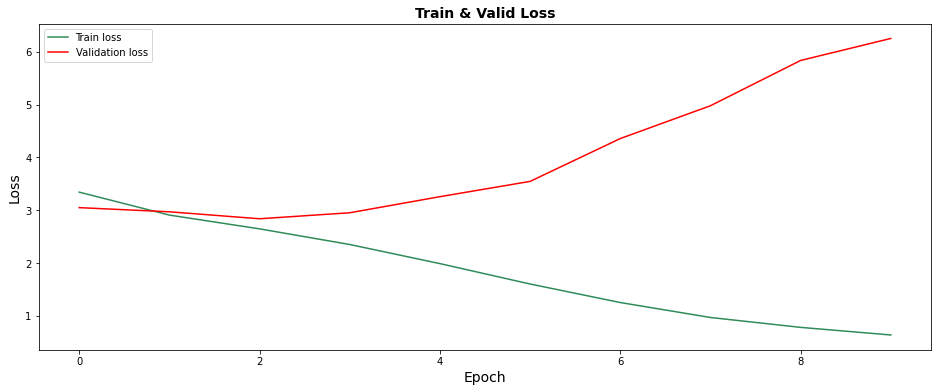

In [22]:
#x = cp.arange(len(train_acc_list)).get()
fig = plt.figure()
#x = list(range(0, len(train_acc) * 50, 50))
x=range(0, len(train_losses))
ax = sns.lineplot(x = x, y = train_losses, color='seagreen', label = 'Train loss')
#sns.lineplot(x = x, y = train_acc_5_list, color='royalblue', label = 'Train Top 5 accuracy')
sns.lineplot(x = x, y = valid_losses, color='red', label = 'Validation loss')
#sns.lineplot(x = x, y = valid_acc_5_list, color='gold', label = 'Validation Top 5 accuracy')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Train & Valid Loss", size = 14, fontweight='bold')
ax.legend()
fig.set_figheight(6)
fig.set_figwidth(16)

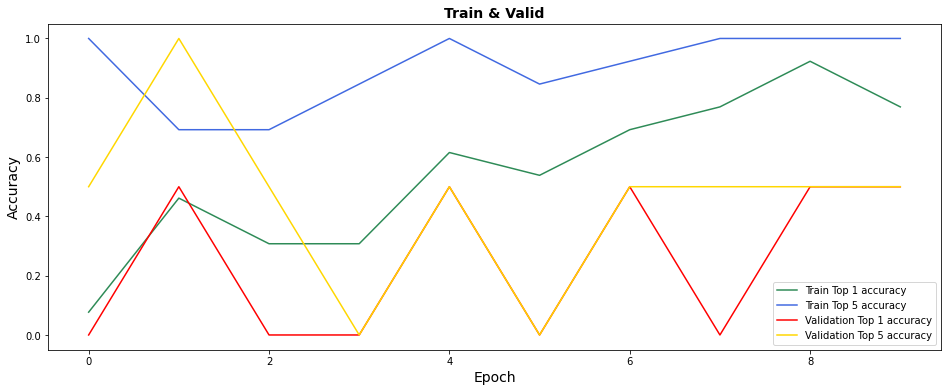

In [26]:
#x = cp.arange(len(train_acc_list)).get()
fig = plt.figure()
#x = list(range(0, len(train_acc) * 50, 50))
x=range(0, len(train_acc_list))
ax = sns.lineplot(x = x, y = train_acc_list, color='seagreen', label = 'Train Top 1 accuracy')
sns.lineplot(x = x, y = train_acc_5_list, color='royalblue', label = 'Train Top 5 accuracy')
sns.lineplot(x = x, y = valid_acc_list, color='red', label = 'Validation Top 1 accuracy')
sns.lineplot(x = x, y = valid_acc_5_list, color='gold', label = 'Validation Top 5 accuracy')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Accuracy", size = 14)
ax.set_title("Train & Valid", size = 14, fontweight='bold')
ax.legend()
fig.set_figheight(6)
fig.set_figwidth(16)

# test

In [31]:
test_losses = []
test_acc_list = []
test_acc_5_list = []
num_epochs=1
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    test_loss = 0.0
    model.eval()
    for X_test_batch, Y_test_batch in test_loader:

        X_test_batch = X_test_batch.to(device)
        Y_test_batch = Y_test_batch.to(device)

        mean, std = X_test_batch.mean(), X_test_batch.std()
        X_test_batch = custom_normalization(X_test_batch, mean, std)

        output = model(X_test_batch)

        loss = criterion(output, Y_test_batch.long())

        # update-average-testidation-loss 
        test_loss += loss.item() * X_test_batch.size(0)

        # calculate-average-losses
        test_loss = test_loss/len(test_loader.sampler)
        test_losses.append(test_loss)

        #if epoch % 10 == 0:
        # print-training/testidation-statistics 
        print('Epoch: {} \ttestidation Loss: {:.6f}'.format(epoch, test_loss))
        if epoch % 1 == 0:
            test_acc = model.accuracy(X_test_batch, Y_test_batch, k= 1)  
            test_acc_5 = model.accuracy(X_test_batch, Y_test_batch, k= 5)
            test_acc_list.append(test_acc)     
            test_acc_5_list.append(test_acc_5)

            #print("train acc, test acc , test acc| " + str(train_acc) + ", " + str(testid_acc) + ", " + str(test_acc)+'；' +"train acc_5, testid acc_5, test acc_5| " + str(train_acc_5) + ", " + str(testid_acc_5) + ", " + str(test_acc_5))
            print("epochs：{},acc-top1 test：{:.6} ".format(epoch, test_acc.item())+'；' 
                  +"acc-top5 test：{:.6}".format( test_acc_5.item()))

Epoch: 1 	testidation Loss: 5.996452
epochs：1,acc-top1 test：0.2 ；acc-top5 test：0.486667
